In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 


In [3]:
df = pd.read_csv('ais_train.csv', sep='|')
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [4]:
print(df.info())

print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
None
time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0


##### Check values that are missing/default in the dataset

Some values are marked as missing by using specific values like 360 for COG and 1023 for SOG, and ROT

COG - Course over Ground, relative to the north vector 
* 360 = not available = default. 
* 360.1 - 409.5 should not be used 

SOG - Speed over Ground 
* Speed over ground in 1/10 knot steps (0-102.2 knots)
* 1 023 = not available, 1 022 = 102.2 knots or higher

Rate of Turn 
* 0 to +126 = turning right at up to 708 deg per min or higher
* 0 to -126 = turning left at up to 708 deg per min or higher Values between 0 and 708
* +127 = turning right at more than 5 deg per 30 s (No TI available), when the ship is turning fast there is no turn indicator available 
* -127 = turning left at more than 5 deg per 30 s (No TI available)
* -128 (80 hex) indicates no turn information available (default).

Heading 
- Degrees (0-359) (511 indicates not available = default)

Picture of AIS system

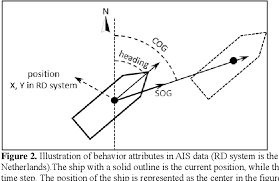

In [5]:
initial_count = df.shape[0]
df.drop_duplicates(inplace=True)
df.head()
dropped_count = initial_count - df.shape[0]
print(f"Number of rows dropped: {dropped_count}")

Number of rows dropped: 0


In [6]:
df['cog'] = df['cog'].apply(lambda x: np.nan if 360 <= x <= 409.5 else x)

# Replace 1023 and values over 102.2 in SOG with NaN
df['sog'] = df['sog'].replace([1023, np.nan])

# Replace other variables similarly
# For ROT, replace -128 (no turn info) with NaN
df['rot'] = df['rot'].replace([-128], np.nan)

# For heading, replace 511 (no heading info) with NaN
df['heading'] = df['heading'].replace([511], np.nan)

C:\Users\ingvi\AppData\Local\Temp\ipykernel_25232\2725894.py:4: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df['sog'] = df['sog'].replace([1023, np.nan])


In [7]:
# Check if the replacement worked for COG (should not contain values between 360.1 and 409.5)
print(df['cog'].describe())

print(df[['cog', 'sog', 'rot', 'heading']].isnull().sum())


count    1.516207e+06
mean     1.775472e+02
std      1.072909e+02
min      0.000000e+00
25%      7.800000e+01
50%      1.830000e+02
75%      2.680000e+02
max      3.599000e+02
Name: cog, dtype: float64
cog        5858
sog           0
rot           0
heading    4895
dtype: int64


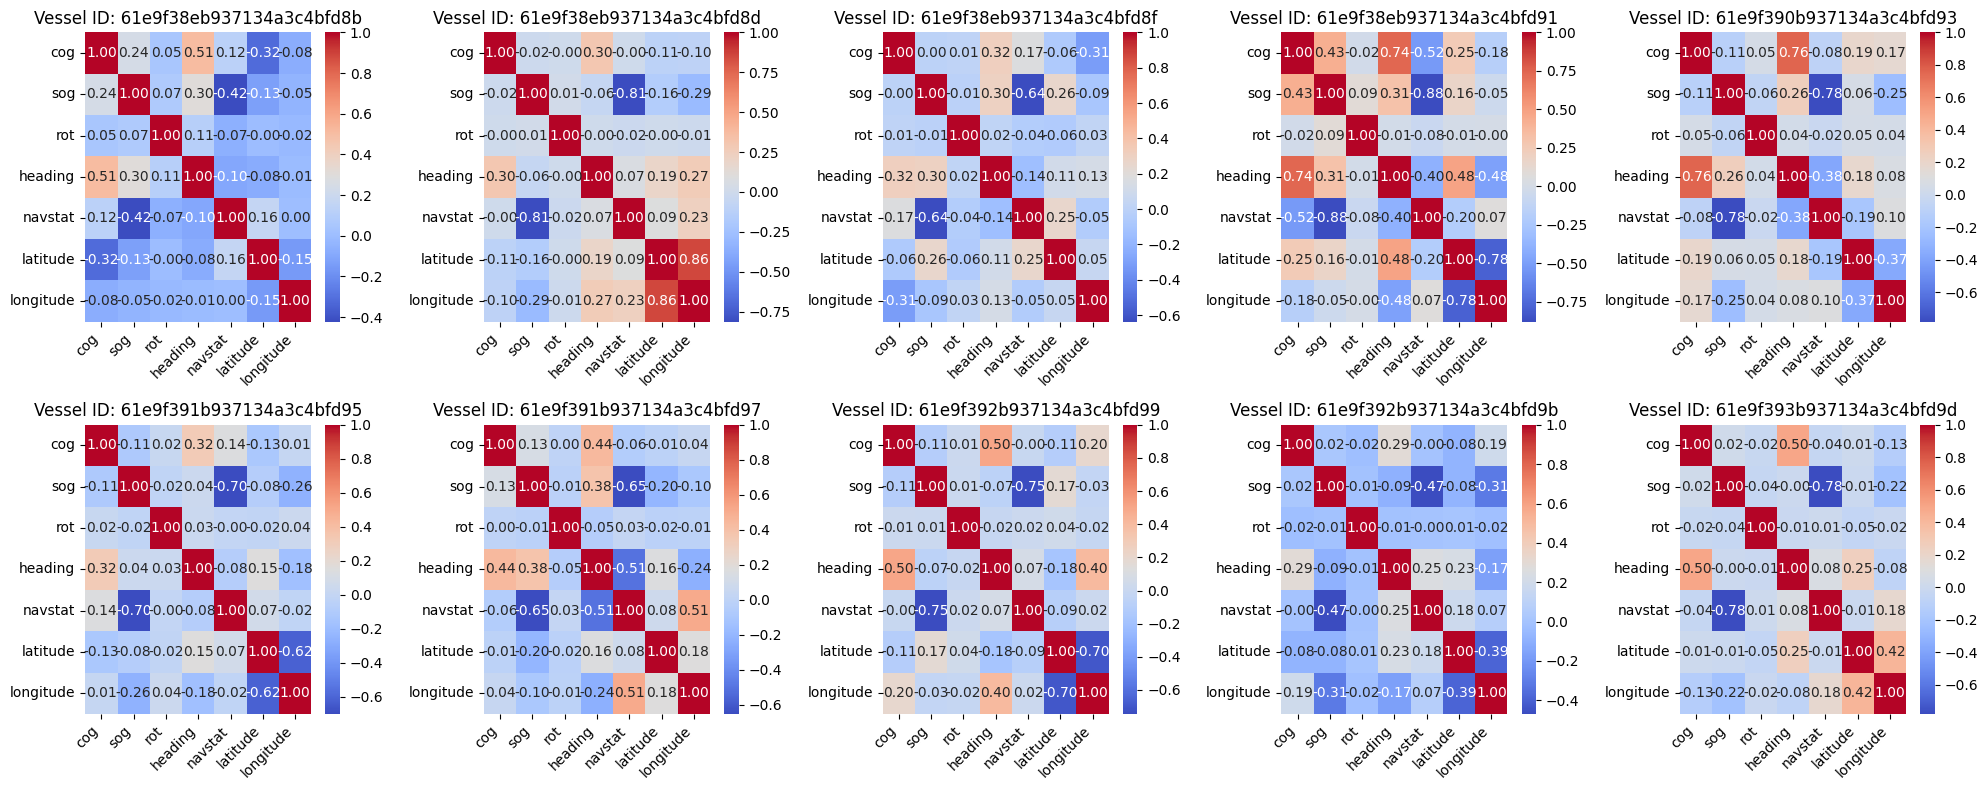

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Assuming df is your DataFrame
# Drop the unwanted columns
df_filtered = df.drop(columns=['time', 'etaRaw', 'portId'])

# Group by vesselId
grouped = df_filtered.groupby('vesselId')
first_ten_groups = list(itertools.islice(grouped, 10))

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the first ten groups and plot the correlation heatmap
for ax, (vessel_id, group) in zip(axes, first_ten_groups):
    # Select only numeric columns for correlation calculation
    numeric_group = group.select_dtypes(include=[float, int])
    
    # Calculate the correlation matrix for the current vessel
    correlation_matrix = numeric_group.corr()
    
    # Plot the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
    ax.set_title(f'Vessel ID: {vessel_id}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()